# Modelo CLIP y la importancia de los embeddings multimodales

CLIP, que significa Contrastive Language-Image Pretraining, es un modelo de aprendizaje profundo desarrollado por OpenAI en 2021. Los embeddings de CLIP para imágenes y texto comparten el mismo espacio, lo que permite comparaciones directas entre las dos modalidades. Esto se logra entrenando el modelo para acercar imágenes y textos relacionados mientras separa los no relacionados. Este artículo explicará cómo funciona CLIP y lo guiará a través de un ejemplo para entrenar el modelo CLIP utilizando el dataset `flicker30k`.

## Problemas de los enfoques anteriores de Computer Vision

Para empezar a entender bien la importancia de un modelo como CLIP, primero tenemos que centrarnos en entender cuáles son los puntos débiles que hacen tambalear a muchos de los modelos de computer vision preexistentes.

Aunque estos modelos son poderosos y versátiles, tienen limitaciones notables. Por ejemplo, una red neuronal convolucional entrenada para clasificar perros y gatos puede enfrentar dificultades al clasificar imágenes de caballos. Esto se debe a que, una vez entrenada, la red está fijada en su tarea inicial y debemos modificarla para abordar nuevas tareas.

Esta falta de flexibilidad ha llevado al desarrollo de una tendencia importante: trabajar con modelos preentrenados en grandes conjuntos de datos de imágenes variadas haciendo finetuning. Al utilizar un modelo preentrenado, se aprovechan los patrones aprendidos previamente para tareas diversas. Por ejemplo, si se necesita un clasificador de perros, gatos y caballos, simplemente se modifica la arquitectura del modelo agregando una neurona extra a la capa final para la clasificación.

Sin embargo, este enfoque también presenta desafíos. Primero, se requiere un conocimiento de la arquitectura original del modelo preentrenado. Segundo, se necesitan conjuntos de datos masivos etiquetados manualmente. Etiquetar imágenes de manera precisa y exhaustiva puede ser complicado, especialmente cuando una imagen puede tener múltiples interpretaciones. Esto significa que las etiquetas deben ser más detalladas, lo que aumenta la complejidad del proceso de etiquetado.



CLIP es una innovadora propuesta desarrollada por OpenAI que aborda muchos de los desafíos previamente discutidos. ¿Cómo lo logra? Combinando la potencia de los modelos de visión con los modelos de lenguaje. En lugar de utilizar el enfoque tradicional de supervisar las imágenes con etiquetas, CLIP utiliza la supervisión a través del lenguaje natural. Consta de dos modelos: uno de visión, encargado de analizar las imágenes, y otro de lenguaje, que procesa el texto de entrada. La tarea principal de CLIP es `emparejar imágenes con descripciones`, aprendiendo a asociar correctamente cada imagen con la descripción más adecuada.

Esta idea aparentemente simple tiene implicaciones significativas. En primer lugar, CLIP no requiere imágenes etiquetadas manualmente, sino que puede entrenarse con descripciones en lenguaje natural. OpenAI ha entrenado este sistema con más de 250 millones de pares de imágenes y descripciones obtenidas de Internet, lo que amplía enormemente el alcance y la diversidad del conjunto de datos. Además, la forma en que se entrena CLIP es crucial: no solo debe aprender a asociar correctamente las imágenes con las descripciones adecuadas, sino también a discernir por qué ciertas descripciones no son apropiadas para una imagen dada.



## ¿Qué es CLIP?



CLIP está diseñado para predecir qué N × N pares potenciales (imagen, texto) dentro del lote están realmente asociados. Para lograr esto, CLIP establece un `espacio de embeddings multimodal` mediante el entrenamiento conjunto de un codificador de imágenes y un codificador de texto.

La función de pérdida de CLIP tiene como objetivo maximizar la `similitud del coseno` entre los embeddings de la imagen y del texto para los N pares genuinos en el lote y al mismo tiempo minimizar la similitud del coseno para los N² - N pares incorrectos. El proceso de optimización implica el uso de una función de pérdida de `entropía cruzada simétrica` que opera con estas puntuaciones de similitud.

A continuación se presenta un pseudocódigo (tomado del artículo original) que describe la implementación principal de CLIP.



```
# image_encoder - ResNet or Vision Transformer
# text_encoder - CBOW or Text Transformer
# I[n, h, w, c] - minilote de imágenes alineadas
# T[n, l] - minilote de descripciones alineadas
# W_i[d_i, d_e] - proyección aprendida del embedding de la imagen al espacio multimodal
# W_t[d_t, d_e] - proyección aprendida del embedding de la descripción al espacio multimodal
# t - parámetro de temperatura aprendido

# extraer representaciones de características de cada modalidad
I_f = image_encoder(I) #[n, d_i]
T_f = text_encoder(T) #[n, d_t]

# obtener representaciones multimodales conjuntas [n, d_e]
I_e = l2_normalize(np.dot(I_f, W_i), axis=1)
T_e = l2_normalize(np.dot(T_f, W_t), axis=1)

# cálculo de las similitudes de cosenos por pares escaladas [n, n]
logits = np.dot(I_e, T_e.T) * np.exp(t)

# cálculo de la función de pérdida simétrica
labels = np.arange(n)
loss_i = cross_entropy_loss(logits, labels, axis=0)
loss_t = cross_entropy_loss(logits, labels, axis=1)
loss = (loss_i + loss_t)/2
```



En las siguientes secciones haremos una descripción paso por paso de cada línea del pseudocódigo y su implementación usando Pytorch.

### Descripción General del Modelo



ClIP utiliza dos arquitecturas separadas como columna vertebral para codificar conjuntos de datos de texto y visión:
* `image_encoder`: representa la arquitectura de red neuronal (por ejemplo, ResNet o Vision Transformer) responsable de codificar imágenes.
* `text_encoder`: representa la arquitectura de red neuronal (por ejemplo, CBOW, BERT o Text Transformer) responsable de codificar información textual.

El modelo CLIP original entrenó desde cero si tanto el encoder de imágenes como el encoder de texto con debido al gran volumen del conjunto de datos (400 millones de pares de imagen-texto) que utilizaron. En el ejemplo de este tutorial, haremos las cosas de manera un poco diferente. Comenzaremos con pesos previamente entrenados de los modelos resnet (para imágenes) y distilbert (para texto) para inicializar estos módulos.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*LEc2qQNO6Vumrv5lqSpuhA.png)

### Datos de Entrada

El modelo toma como entrada un lote de n pares de imágenes y textos donde:

* `I[n, c, h, w]`: representa un minilote de imágenes alineadas, donde n es el tamaño del lote, h es la altura de la imagen, w es el ancho de la imagen y c es el número de canales.
* `T[n, l]`: representa un minilote de textos alineados, donde n es el tamaño del lote y l es la longitud de la secuencia textual.

### Extracción de Features

* `I_f = image_encoder(I)`: extrae embeddings (`I_f`) del encoder de imágenes. La forma de I_f es `[n, d_i]`, donde d_i es la dimensionalidad de los embeddings de la imagen.
* `T_f = text_encoder(T)`: extrae embeddings (`T_f`) del encoder de texto. La forma de T_f es `[n, d_t]`, donde d_t es la dimensionalidad de los embeddings de texto.

In [1]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer
import torch.nn.functional as F
from torchvision import models

I_f = models.resnet34(pretrained=True)      # for encoding images
T_f= AutoModel.from_pretrained("distilbert-base-multilingual-cased") # for encoding captions

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The

### Proyecciones Aprendidas

* `W_i[d_i, d_e]`: representa la matriz de proyección aprendida para mapear los embeddings de las imágenes (`I_f`) a un espacio de embedding multimodal (`I_e`). La forma de W_i es `[d_i, d_e]`, donde d_e es la dimensionalidad deseada del espacio de embedding multimodal.
* `W_t[d_t, d_e]`: representa la matriz de proyección aprendida para mapear los embeddings de texto (`T_f`) a un espacio de embedding multimodal(`T_e`). La forma de W_t es `[d_t, d_e]`.

La operación de proyección se puede implementar  utilizando una red neuronal con dos capas densas, cuyos pesos son la matriz de proyección aprendida. En la mayoría de los casos, los pesos de la matriz de proyección son los únicos pesos con gradientes activos durante el proceso de entrenamiento. Además, la capa de proyección juega un papel crucial a la hora de alinear las dimensiones de los embeddings de imágenes y texto, asegurando que tengan el mismo tamaño.

In [2]:
import torch
import torch.nn as nn
class Projection(nn.Module):
    def __init__(self, d_in: int, d_out: int, p: float = 0.5) -> None:
        super().__init__()
        self.linear1 = nn.Linear(d_in, d_out, bias=False)
        self.linear2 = nn.Linear(d_out, d_out, bias=False)
        self.layer_norm = nn.LayerNorm(d_out)
        self.drop = nn.Dropout(p)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        embed1 = self.linear1(x)
        embed2 = self.drop(self.linear2(F.gelu(embed1)))
        embeds = self.layer_norm(embed1 + embed2)
        return embeds

### Arquitectura de los Encoders

El siguiente código ilustra el procesamiento secuencial de datos de imagen y texto. Inicialmente, los datos se procesan a través del encoder base, seguido de la capa de proyección y finalmente, se generan embeddings normalizadas para ambas modalidades.


In [3]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer
import torch.nn.functional as F
from torchvision import models



class VisionEncoder(nn.Module):
    def __init__(self, d_out: int) -> None:
        super().__init__()
        base = models.resnet34(pretrained=True)
        d_in = base.fc.in_features
        base.fc = nn.Identity()
        self.base = base
        self.projection = Projection(d_in, d_out)
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        projected_vec = self.projection(self.base(x))
        projection_len = torch.norm(projected_vec, dim=-1, keepdim=True)
        return projected_vec / projection_len


class TextEncoder(nn.Module):
    def __init__(self, d_out: int) -> None:
        super().__init__()
        self.base = AutoModel.from_pretrained(Config.text_model)
        self.projection = Projection(Config.transformer_embed_dim, d_out)
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        out = self.base(x)[0]
        out = out[:, 0, :]  # get CLS token output
        projected_vec = self.projection(out)
        projection_len = torch.norm(projected_vec, dim=-1, keepdim=True)
        return projected_vec / projection_len


### Función de Pérdida


* `logits = np.dot(I_e, T_e.T) * np.exp(t)`: Calcula similitudes de coseno por pares entre embeddings de imagen y texto, escaladas por un parámetro de temperatura aprendido t.

En este ejemplo, usamos indistintamente los términos similitud y logits de la misma manera que se usó en el artículo original. No incluiremos el parámetro de temperatura t en esta clase.

CLIP utiliza la pérdida contrastiva para acercar los embeddings de las imágenes y los textos relacionados mientras aleja los no relacionados.

* `labels = np.arange(n)`: Genera etiquetas que representan los índices del lote.
* `loss_i = cross_entropy_loss(logits, etiquetas, axis=0)`: Calcula la pérdida de entropía cruzada a lo largo del eje de la imagen.
* `loss_t = cross_entropy_loss(logits, etiquetas, axis=1)`: Calcula la pérdida de entropía cruzada a lo largo del eje del texto.
* `loss = (loss_i + loss_t)/2`: Calcula el promedio simétrico de las pérdidas de imagen y texto.

In [4]:
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def CLIP_loss(logits: torch.Tensor) -> torch.Tensor:
    # Asumimos que n es el número de clases
    n = logits.shape[1]

    # Creamos el tensor de etiquetas
    labels = torch.arange(n).to(device)

    # Calculamos la entropía cruzada a lo largo de los ejes 0 y 1
    loss_i = F.cross_entropy(logits.transpose(0, 1), labels, reduction="mean")
    loss_t = F.cross_entropy(logits, labels, reduction="mean")

    # Calculamos la pérdida final
    loss = (loss_i + loss_t) / 2

    return loss

def metrics(similarity: torch.Tensor):
    y = torch.arange(len(similarity)).to(similarity.device)
    img2cap_match_idx = similarity.argmax(dim=1)
    cap2img_match_idx = similarity.argmax(dim=0)

    img_acc = (img2cap_match_idx == y).float().mean()
    cap_acc = (cap2img_match_idx == y).float().mean()

    return img_acc, cap_acc

### Modelo CLIP personalizado final



Combinando todas las diferentes piezas, el modelo CLIP personalizado final se parece al siguiente:

In [5]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from typing import List, Tuple


class CustomModel(nn.Module):
    def __init__(self, lr: float = 1e-3) -> None:
        super().__init__()
        self.vision_encoder = VisionEncoder(Config.embed_dim)
        self.caption_encoder = TextEncoder(Config.embed_dim)
        self.tokenizer = Tokenizer(AutoTokenizer.from_pretrained(Config.text_model, use_fast=False))
        self.lr = lr
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def forward(self, images, text):
        text = self.tokenizer(text).to(self.device)

        image_embed = self.vision_encoder(images)
        caption_embed = self.caption_encoder(text["input_ids"])
        similarity = caption_embed @ image_embed.T
        loss = CLIP_loss(similarity)
        img_acc, cap_acc = metrics(similarity)
        return loss, img_acc, cap_acc

class Tokenizer:
    def __init__(self, tokenizer: BertTokenizer) -> None:
        self.tokenizer = tokenizer

    def __call__(self, x: str) -> AutoTokenizer:
        return self.tokenizer(
            x, max_length=Config.max_len, truncation=True, padding=True, return_tensors="pt"
        )




## Ejemplo de Entrenamiento

Este ejemplo demuestra el proceso de creación de dataset de imágenes con descripciones y el entrenamiento de un modelo CLIP personalizado.

El objetivo es entrenar un encoder de visión y un encoder de texto conjuntamente para proyectar la representación de imágenes y sus descripciones en el mismo espacio latente, de modo que los embeddings de las descripciones estén ubicadas cerca de los embeddings de las imágenes que describen.

### Dataset y Dataloaders

Nuestro modelo CLIP personalizado se entrenará utilizando el conjunto de datos `flickr30k`. Este dataset comprende más de 31.000 imágenes, cada una con un mínimo de cinco descripciones independientes generadas por humanos. Usaremos dos descripciones para cada imagen en este ejemplo para tener un total de 62 000 pares de imágenes y texto para el entrenamiento.

In [6]:
!pip install datasets --quiet

In [7]:
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
import torch
from torchvision import transforms
from PIL import Image

# Define un dataset personalizado para Flickr30k
class Flickr30kDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.dataset = load_dataset("nlphuji/flickr30k", cache_dir="./huggingface_data")
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        self.cap_per_image = 2

    def __len__(self):
        return self.dataset.num_rows["test"] * self.cap_per_image

    def __getitem__(self, idx):
        original_idx = idx // self.cap_per_image
        # image_path = self.dataset[idx]["image_path"]
        image = self.dataset["test"][original_idx]["image"].convert("RGB")
        image = self.transform(image)

        # You might need to adjust the labels based on your task
        caption = self.dataset["test"][original_idx]["caption"][idx % self.cap_per_image]

        return {"image": image, "caption": caption}

# Create an instance of the custom dataset
flickr30k_custom_dataset = Flickr30kDataset()


Generating test split:   0%|          | 0/31014 [00:00<?, ? examples/s]

Las constantes clave del modelo incluyen:
* `embed_dim` para las representaciones aprendidas,
* `transformer_embed_dim` para los embeddings del transformer y
* `max_len` para la longitud máxima de entrada de texto.

El modelo de texto elegido es `distilbert-base-multilingual-cased`. El entrenamiento abarca 3 épocas con un tamaño de lote de 128, que son las constantes que se incorporarán a la construcción y el entrenamiento del modelo.

In [8]:
from dataclasses import dataclass


@dataclass
class Config:
    """
    Configuration class for the CLIP training script.
    """

    embed_dim: int = 512  # Embedding dimension
    transformer_embed_dim: int = 768  # Transformer embedding dimension
    max_len: int = 32  # Maximum text length
    text_model: str = "distilbert-base-multilingual-cased"  # Text model name
    epochs: int = 5  # Number of training epochs
    batch_size: int = 128  # Batch size

El DataLoader está configurado para una iteración eficiente durante el entrenamiento, proporcionando acceso organizado a pares de imágenes y títulos.

In [9]:
# Create the DataLoader
clip_dataloader = DataLoader(flickr30k_custom_dataset,
                             batch_size=Config.batch_size,
                             shuffle=True,
                             num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


A continuación se muestra un ejemplo de un par imagen-descripción en uno de los lotes del dataset.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


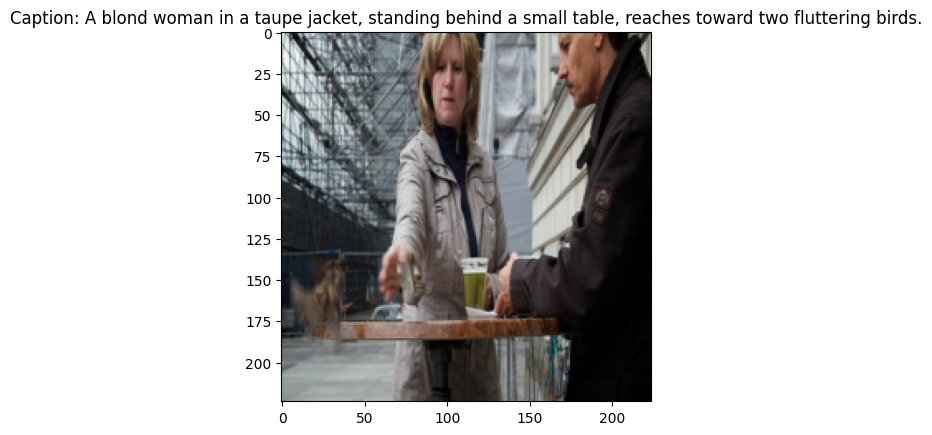

In [10]:
import numpy as np
import matplotlib.pyplot as plt
# Create an iterator from the dataloader
data_iter = iter(clip_dataloader)

# Get one batch
batch = next(data_iter)


image = batch["image"][0]  # Assuming batch size is greater than 0
caption = batch["caption"][0]

# Convert the image tensor to a NumPy array and permute dimensions
image_np = np.transpose(image.numpy(), (1, 2, 0))

# Display the image and caption
plt.imshow(image_np)
plt.title(f"Caption: {caption}")
plt.show()

In [11]:
print("example of a caption in abatch:",  batch["caption"][0])
print("number of captions in each batch:",len(batch["caption"]))

example of a caption in abatch: A blond woman in a taupe jacket, standing behind a small table, reaches toward two fluttering birds.
number of captions in each batch: 128


Aquí, iniciamos nuestro CustomModel y lo enviamos al dispositivo (CPU o GPU). Además, especificamos los parámetros a optimizar durante todo el proceso de entrenamiento. Dado que hemos congelado las capas base de los encoders de texto e imágen, solo los parámetros asociados con la capa de proyección se entrenarán en el nuevo conjunto de datos.

In [12]:
# Creamos una instancia de nuestro modelo
model = CustomModel().to(device)

# Define optimizer
optimizer = torch.optim.Adam([
    {'params': model.vision_encoder.parameters()},
    {'params': model.caption_encoder.parameters()}
], lr=model.lr)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

### Entrenamiento del Modelo

El siguiente bucle de entrenamiento se realizó con una máquina GPU Tesla T4 (g4dn-xlarge) durante 3 épocas de entrenamiento. Recuerde activar el uso de GPU en colab desde la pestaña `Entorno de ejecución`.

In [13]:
start_epoch = 0
num_epochs = 3

batch_zero = True
for epoch in range(start_epoch, num_epochs):
    model.train()
    for batch in clip_dataloader:
        image = batch["image"].to(device)
        text = batch["caption"]
        # images, text = batch
        loss, img_acc, cap_acc = model(image, text)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_zero:
          print(f"Epoch [{0}/{num_epochs}], Batch Loss: {loss.item()}")
          batch_zero = False


    # Print training statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Batch Loss: {loss.item()}")

print("Training complete.")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch [0/3], Batch Loss: 4.852604866027832
Epoch [1/3], Batch Loss: 3.8079833984375
Epoch [2/3], Batch Loss: 3.89443302154541
Epoch [3/3], Batch Loss: 3.828665256500244
Training complete.


## Uso del Modelo Preentrenado


La principal fortaleza de CLIP es su capacidad para relacionar texto e imágenes de manera robusta. Esto lo hace especialmente útil en cualquier tarea que requiera entender y manipular información visual y textual de forma integrada.

Algunas de estas aplicaciones son:

1. **Búsqueda y recuperación de imágenes basadas en texto**:
   - **Image Search**: Dado un texto descriptivo, el modelo puede buscar y recuperar imágenes que coincidan con la descripción.
   - **Text-to-Image Retrieval**: Dado un conjunto de imágenes y una consulta en texto, el modelo puede identificar cuál de las imágenes es más relevante para la consulta.

2. **Búsqueda y recuperación de texto basado en imágenes**:
   - **Image Captioning**: Dada una imagen, el modelo puede generar descripciones en texto que correspondan a la imagen.
   - **Image-to-Text Retrieval**: Dado un conjunto de descripciones textuales y una imagen, el modelo puede identificar cuál de las descripciones es más relevante para la imagen.

3. **Clasificación de imágenes**:
   - **Zero-Shot Classification**: CLIP puede realizar clasificación de imágenes sin necesidad de entrenar específicamente para una tarea. Solo se necesita proporcionar las etiquetas de clase en forma de texto, y el modelo determinará la clase más probable para una imagen dada.

4. **Generación de contenido**:
   - **Visual Question Answering (VQA)**: Responder preguntas sobre el contenido de una imagen.
   - **Text-based Image Generation**: Utilizando modelos como DALL-E, que se basan en principios similares, se pueden generar imágenes a partir de descripciones textuales.




### Clasificación de Imágenes Zero-Shot

CLIP puede realizar clasificación de imágenes sin necesidad de entrenar específicamente para una tarea. Solo se necesita proporcionar las etiquetas de clase en forma de texto, y el modelo determinará la clase más probable para una imagen dada.

Veamos como hacerlo con nuestro CLIP personalizado y con la versión oficial de OpenAI.

#### Usando nuestro modelo

Ya que hemos entrenado nuestro propio modelo CLIP, podemos generar una función `predict` que preprocese las entradas y las pase por el modelo para hacer clasificación sin necesidad de hacer fine tuning.

In [ ]:
def predict(img, classes, model, device):
    # 1. Preprocesamiento de la imagen
    img = flickr30k_custom_dataset.transform(img).unsqueeze(0).to(device)

    # 2. Codificación de la imagen
    image_embed = model.vision_encoder(img)

    # 3. Preparación de los textos de las clases
    text = ["a picture of a " + x for x in classes]
    text = model.tokenizer(text).to(device)

    # 4. Codificación de los textos
    caption_embed = model.caption_encoder(text["input_ids"])

    # 5. Cálculo de la similitud
    similarity = caption_embed @ image_embed.T

    # 6. Aplicación de softmax para obtener probabilidades
    return similarity.softmax(dim=0)


Vamos paso a paso:

1. **Preprocesamiento de la imagen**:
    ```python
    img = flickr30k_custom_dataset.transform(img).unsqueeze(0).to(device)
    ```
    Aquí, la imagen `img` se transforma utilizando un método de preprocesamiento definido en el dataset `flickr30k_custom_dataset`. Luego, la imagen transformada se redimensiona con `unsqueeze(0)` para agregar una dimensión de lote (batch), convirtiéndola en un tensor de 4 dimensiones (1, C, H, W). Finalmente, se mueve a la `device` especificada (por ejemplo, GPU).

2. **Codificación de la imagen**:
    ```python
    image_embed = model.vision_encoder(img)
    ```
    La imagen preprocesada se pasa a través del codificador de visión (`vision_encoder`) del modelo, obteniendo un vector de embeddings de la imagen (`image_embed`).

3. **Preparación de los textos de las clases**:
    ```python
    text = ["a picture of a " + x for x in classes]
    text = model.tokenizer(text).to(device)
    ```
    Se generan frases descriptivas para cada clase en la lista `classes`, con el formato "a picture of a [clase]". Estas frases se tokenizan usando el tokenizer del modelo y se convierten a tensores que se mueven al dispositivo especificado (`device`).

4. **Codificación de los textos**:
    ```python
    caption_embed = model.caption_encoder(text["input_ids"])
    ```
    Los textos tokenizados se pasan a través del codificador de captions (`caption_encoder`) del modelo, obteniendo un vector de embeddings de los textos (`caption_embed`).

5. **Cálculo de la similitud**:
    ```python
    similarity = caption_embed @ image_embed.T
    ```
    Se calcula la similitud entre los embeddings de las captions y el embedding de la imagen utilizando el producto interno (`@`), que es una operación de multiplicación de matrices. Aquí se multiplica el embedding de los textos (`caption_embed`) por la transpuesta del embedding de la imagen (`image_embed.T`).

6. **Aplicación de softmax para obtener probabilidades**:
    ```python
    return similarity.softmax(dim=0)
    ```
    Finalmente, se aplica la función softmax a las similitudes calculadas a lo largo de la dimensión 0 (las diferentes clases) para convertirlas en probabilidades. El resultado es un tensor donde cada valor representa la probabilidad de que la imagen corresponda a cada una de las clases dadas.



En resumen, esta función toma una imagen y una lista de clases, y devuelve un tensor de probabilidades que indica cuán probable es que la imagen pertenezca a cada una de las clases especificadas.

Veamos que tan bien le va clasificando entre perros y gatos la siguiente imagen.

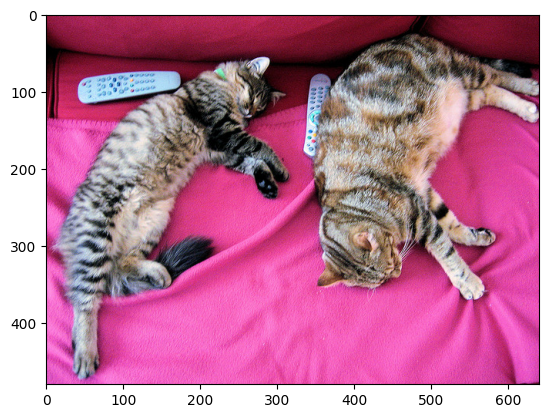

In [72]:
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)
plt.show()

In [73]:
predict(image, ["cat","dog"], model, device)


tensor([[0.4874],
        [0.5126]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Podemos ver que nuestro modelo no está muy seguro de la respuesta aunque está ligeramente inclinado a contestar perro. Esto puede significar que nuestro modelo requiere más epochs de entrenamiento. Veamos si el modelo oficial de OpenAI realiza una mejor tarea.

#### Usando la versión oficial de CLIP

El siguiente código muestra una función predict equivalente a la anterior, pero que utiliza la versión de OpenAI de CLIP que viene incluida en HuggingFace. Para ello haremos uso directo de unas clases preparadas para la tarea:

   - `CLIPModel.from_pretrained("openai/clip-vit-base-patch32")`: Carga un modelo CLIP preentrenado, que contiene tanto un codificador de imágenes como un codificador de texto.
   - `CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")`: Carga el procesador asociado, que se encarga de transformar imágenes y texto en el formato adecuado para el modelo CLIP.

In [75]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import torch

# Cargar el modelo CLIP preentrenado y el procesador
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def predict(image, classes, model, processor):
    # Procesar la imagen y el texto para convertirlos en tensores adecuados para el modelo
    inputs = processor(
        text=classes,  # Lista de descripciones de texto que representan las clases
        images=image,  # Imagen proporcionada como parámetro
        return_tensors="pt",  # Retornar tensores de PyTorch
        padding=True,  # Añadir padding si es necesario
    )

    # Pasar las entradas procesadas al modelo CLIP para obtener las salidas
    outputs = model(**inputs)

    # Extraer los logits para la imagen, que representan la similitud con cada texto
    logits_per_image = outputs.logits_per_image

    # Aplicar softmax a los logits para obtener probabilidades
    probs = logits_per_image.softmax(dim=1)

    return probs




A continuación haremos la prueba con la misma imagen de los gatos para corroborar si hay un mejor desempeño.

In [77]:
# Ejemplo de uso de la función
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
classes = ["a photo of a cat", "a photo of a dog"]

probs = predict(image, classes, model, processor)
print(probs)


tensor([[0.9949, 0.0051]], grad_fn=<SoftmaxBackward0>)


Podemos ver que este modelo hace una tarea fenomenal, estableciendo sin lugar a dudas que se trata de un gato. Uno podría preguntarse por qué el resultado es tan superior. La respuesta viene en la diferencia en los tamaños de los datasets y la cantidad de épocas realizadas.

El entrenamiento de modelos a gran escala, como CLIP, generalmente implica entrenamientos durante varias semanas o incluso meses en grandes clústeres de GPU. Durante este tiempo, los modelos pasan por miles o incluso decenas de miles de épocas para optimizar los parámetros y aprender representaciones de datos de alta calidad. Mientras que el conjunto de datos contiene aproximadamente 400 millones de pares de imágenes y textos.

# Conclusión

En conclusión, esta clase ha explorado el modelo CLIP y ha descubierto su potencial para una amplia gama de aplicaciones. A medida que entendemos las aplicaciones de CLIP, resulta evidente que su impacto va mucho más allá de las expectativas iniciales, allanando el camino para soluciones innovadoras en diversos campos. CLIP fue el primer modelo exitoso que cerró la brecha entre diferentes modalidades y abrió vías para innovaciones interdisciplinarias.